<div style="display:block;width:100%;margin:auto;" direction=rtl align=center>
    <br><br>
    <div style="width:100%;margin:100;display:block;background-color:#fff0;" display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">
            <tr>
                <td style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b> Large Language Models (LLM)</b><br><br>Final Project</font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
            </tr>
        </table>
        <h1> Farzad Jannati- Abolfazl Asarian Nejad-Shahriar Rahimi Rad </h1>
        <h1> Prof. MJ. Dousti & Yadollah Yaghoobzadeh </h1>
    </div>
</div>

>[Persian News Headline Generation with LoRA Fine-tuning Llama 3.2](#scrollTo=jyQaSu3tHduo)

>>[Section 1: Environment Setup and Dependencies](#scrollTo=D_467sfmITJi)

>>[Section 2: Hugging Face Authentication & Setup](#scrollTo=Pprzh36OIjmh)

>>>[Hugging Face Authentication](#scrollTo=EvvrGqYCJbVC)

>>>[Mount Google Drive](#scrollTo=rzI35nmlJj71)

>>>[Create output directories](#scrollTo=FD3Ctv82JxHC)

>>>[Helper function for GPU Memory Management](#scrollTo=mFkJv1RSden9)

>>[Section 3: Data Loading and Initial Analysis](#scrollTo=-92nrJRNKCUV)

>>[Section 4: Statistical Analysis and Visualization](#scrollTo=BPieVggZKNO-)

>>[Section 5: Visualization of Dataset Characteristics](#scrollTo=rxJ2yKZ8KsQ6)

>>[Section 6: Advanced Persian Text Preprocessing](#scrollTo=vud0wFX3MwB5)

>>[Section 7: Data Quality Analysis](#scrollTo=ej_wjheANCOl)

>>[Section 8: Prepare Data for Fine-tuning](#scrollTo=gYoJNY_oNhQ3)

>>[Section 9: Model Configuration and Tokenizer Setup](#scrollTo=HpXesgYhNp5x)

>>[Section 10: LoRA Configuration](#scrollTo=LYyqm4I1OKtj)

>>[Section 11: Dataset Preparation for Training](#scrollTo=QAOCJFcfO7ar)

>>[Section 12: Contrastive Loss Implementation](#scrollTo=G_qW5RNBPN3o)

>>[Section 13: Custom Trainer with Multi-task Loss](#scrollTo=VDlHPEQLPbcF)

>>[Section 14: Training Configuration](#scrollTo=_mnud06ZPwdY)

>>[Section 15: Model Training](#scrollTo=Mfb3Y_RJP9jx)

>>[Section 16: Model Evaluation - Generate Headlines](#scrollTo=CyIUJWMkQgtT)

>>[Section 17: Evaluation Metrics](#scrollTo=bmIZGc8JQqoO)

>>[Section 18: Visualization of Results](#scrollTo=H3tOAgnuQ1wW)

>>[Section 19: Qualitative Analysis](#scrollTo=Rl8BJ6gBQ_Cd)

>>[Section 20: Save Model Configuration](#scrollTo=W10NMy1iRGF4)

>>[Section 21: Summary and Conclusions](#scrollTo=0TaE0Aj9RNch)



# Persian News Headline Generation with LoRA Fine-tuning Llama 3.2

## Section 1: Environment Setup and Dependencies

In [1]:
# Install hazm without compiling Wapiti
!pip install --no-cache-dir hazm --no-deps
!pip install nltk tqdm

In [2]:
!pip install python-crfsuite
!pip install flashtext
!pip install fasttext
!pip install gensim

# Download NLTK punkt tokenizer data (needed for hazm's sentence tokenizer)
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Install necessary Python libraries
!pip install evaluate -q
!pip install bert_score -q
!pip install datasets -q
!pip install accelerate -q
!pip install bitsandbytes -q
!pip install peft -q

In [4]:
# Core libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import re
from collections import Counter
import gc
import os
import warnings
warnings.filterwarnings('ignore')

# Hugging Face libraries
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training
)
from datasets import Dataset as HFDataset
import evaluate
from bert_score import score as bert_score

# Persian text processing
import hazm

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## Section 2: Hugging Face Authentication & Setup

### Hugging Face Authentication

In [ ]:
print("🔐 Authenticating with Hugging Face...")
from huggingface_hub import login

# Get token from user
print("Please enter your Hugging Face token:")
HF_TOKEN = input()
login(token=HF_TOKEN)
print("✅ Successfully authenticated with Hugging Face!")

### Mount Google Drive

In [7]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Create output directories

In [8]:
# Create output directories
output_dir = '/content/drive/MyDrive/Context_Aware_Headlines' if IN_COLAB else './Context_Aware_Headlines'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f'{output_dir}/models', exist_ok=True)
os.makedirs(f'{output_dir}/results', exist_ok=True)
os.makedirs(f'{output_dir}/plots', exist_ok=True)

## Section 3: Data Loading and Initial Analysis

In [9]:
print("\n📁 Loading dataset from Google Drive...")

# Download and extract dataset from Google Drive
import zipfile

# Path to your zip file in Google Drive
zip_path = "/content/drive/MyDrive/pn_summary.zip"

# Check if zip file exists
if not os.path.exists(zip_path):
    print("❌ Error: pn_summary.zip not found in Google Drive!")
    print(f"Please make sure the file exists at: {zip_path}")
else:
    print("✅ Found pn_summary.zip in Google Drive")

    # Create data directory
    data_dir = f"{output_dir}/data"
    os.makedirs(data_dir, exist_ok=True)

    # Extract the zip file
    extract_path = f"{data_dir}/pn_summary"
    if not os.path.exists(extract_path):
        print("📦 Extracting pn_summary.zip...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("✅ Extraction completed!")
    else:
        print("✅ Dataset already extracted.")

    # Load train and test datasets with tab separator
    print("\n📊 Loading PN-Summary dataset...")
    try:
        # Try reading with tab separator first
        train_df = pd.read_csv(f"{extract_path}/train.csv", sep='\t')
        test_df = pd.read_csv(f"{extract_path}/test.csv", sep='\t')

        print(f"✅ Train dataset loaded: {len(train_df):,} samples")
        print(f"✅ Test dataset loaded: {len(test_df):,} samples")

        # Check if columns are properly separated
        print(f"\n📋 Dataset Overview:")
        print(f"Train columns: {list(train_df.columns)}")
        print(f"Test columns: {list(test_df.columns)}")

        # Check for missing expected columns
        expected_columns = ['title', 'summary']
        missing_train = [col for col in expected_columns if col not in train_df.columns]
        missing_test = [col for col in expected_columns if col not in test_df.columns]

        if missing_train:
            print(f"⚠️ Missing columns in train dataset: {missing_train}")
        if missing_test:
            print(f"⚠️ Missing columns in test dataset: {missing_test}")

        # If columns are not properly separated, try to fix
        if len(train_df.columns) == 1 or 'title' not in train_df.columns:
            print("🔧 Attempting to fix column separation...")
            # Get the single column name
            single_col = train_df.columns[0]

            # Split the single column into multiple columns
            train_split = train_df[single_col].str.split('\t', expand=True)
            test_split = test_df[single_col].str.split('\t', expand=True)

            # Assign proper column names based on the expected structure
            expected_cols = ['id', 'title', 'article', 'summary', 'category', 'categories', 'network', 'link']

            # Create new dataframes with proper columns
            train_df = pd.DataFrame()
            test_df = pd.DataFrame()

            for i, col_name in enumerate(expected_cols):
                if i < train_split.shape[1]:
                    train_df[col_name] = train_split[i]
                if i < test_split.shape[1]:
                    test_df[col_name] = test_split[i]

            print("✅ Column separation fixed!")
            print(f"Train columns: {list(train_df.columns)}")
            print(f"Test columns: {list(test_df.columns)}")

        # Display sample data
        print(f"\n🔍 Sample data from training set:")
        for i in range(min(3, len(train_df))):
            print(f"\nSample {i+1}:")
            if 'title' in train_df.columns:
                print(f"Title: {train_df.iloc[i]['title'][:100]}...")
            if 'summary' in train_df.columns:
                print(f"Summary: {train_df.iloc[i]['summary'][:150]}...")

    except Exception as e:
        print(f"❌ Error loading datasets: {e}")
        print("Attempting alternative loading methods...")

        # Try with different encodings and separators
        for encoding in ['utf-8', 'utf-8-sig', 'latin1']:
            for sep in ['\t', ',', ';']:
                try:
                    print(f"Trying encoding: {encoding}, separator: '{sep}'")
                    train_df = pd.read_csv(f"{extract_path}/train.csv",
                                         sep=sep, encoding=encoding,
                                         quoting=3, error_bad_lines=False)
                    test_df = pd.read_csv(f"{extract_path}/test.csv",
                                        sep=sep, encoding=encoding,
                                        quoting=3, error_bad_lines=False)

                    print(f"✅ Successfully loaded with encoding: {encoding}, separator: '{sep}'")
                    print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
                    break
                except Exception as inner_e:
                    continue
            else:
                continue
            break


📁 Loading dataset from Google Drive...
✅ Found pn_summary.zip in Google Drive
✅ Dataset already extracted.

📊 Loading PN-Summary dataset...
✅ Train dataset loaded: 82,022 samples
✅ Test dataset loaded: 5,593 samples

📋 Dataset Overview:
Train columns: ['id', 'title', 'article', 'summary', 'category', 'categories', 'network', 'link']
Test columns: ['id', 'title', 'article', 'summary', 'category', 'categories', 'network', 'link']

🔍 Sample data from training set:

Sample 1:
Title: مدیریت فروش نفت در دوران تحریم هوشمندانه عمل کرد...
Summary: مدیرعامل شرکت ملی نفت، عملکرد مدیریت امور بین‎الملل این شرکت را در دوران تحریم بسیار هوشمندانه خواند و گفت: امور بین الملل در دوران پس از تحریم‎ها نیز...

Sample 2:
Title: سبد محصولات پتروشیمی متنوع می‌شود...
Summary: سرپرست مدیریت برنامه‌ریزی و توسعه شرکت ملی صنایع پتروشیمی گفت: تنوع محصولات پتروشیمی ایران با بهره‌برداری از طرح‌های جهش دوم و سوم صنعت پتروشیمی افزای...

Sample 3:
Title: معرفی گوگرد بنتونیتی پالایشگاه خانگیران در نمایشگاه کشاورزی اردب

## Section 4: Statistical Analysis and Visualization

In [10]:
print("\n📈 Performing statistical analysis on datasets...")

def analyze_dataset(df, dataset_name):
    """Comprehensive statistical analysis of the dataset"""

    print(f"\n{'='*60}")
    print(f"Analysis of {dataset_name} Dataset")
    print(f"{'='*60}")

    # Calculate text lengths
    df['title_length'] = df['title'].astype(str).apply(len)
    df['summary_length'] = df['summary'].astype(str).apply(len)
    df['title_words'] = df['title'].astype(str).str.split().str.len()
    df['summary_words'] = df['summary'].astype(str).str.split().str.len()

    print(f"\n📏 Text Length Statistics:")
    for col in ['title_length', 'summary_length', 'title_words', 'summary_words']:
        print(f"\n{col}:")
        print(f"  Mean: {df[col].mean():.2f}")
        print(f"  Median: {df[col].median():.2f}")
        print(f"  Std: {df[col].std():.2f}")
        print(f"  Min: {df[col].min()}")
        print(f"  Max: {df[col].max()}")

    return df

# Analyze both datasets
train_df = analyze_dataset(train_df.copy(), "Training")
test_df = analyze_dataset(test_df.copy(), "Test")


📈 Performing statistical analysis on datasets...

Analysis of Training Dataset

📏 Text Length Statistics:

title_length:
  Mean: 50.18
  Median: 50.00
  Std: 12.97
  Min: 6
  Max: 151

summary_length:
  Mean: 154.08
  Median: 145.00
  Std: 54.51
  Min: 44
  Max: 891

title_words:
  Mean: 9.20
  Median: 9.00
  Std: 2.45
  Min: 1
  Max: 27

summary_words:
  Mean: 28.80
  Median: 27.00
  Std: 10.44
  Min: 9
  Max: 160

Analysis of Test Dataset

📏 Text Length Statistics:

title_length:
  Mean: 50.13
  Median: 50.00
  Std: 12.91
  Min: 12
  Max: 126

summary_length:
  Mean: 154.76
  Median: 146.00
  Std: 55.48
  Min: 51
  Max: 1012

title_words:
  Mean: 9.19
  Median: 9.00
  Std: 2.46
  Min: 2
  Max: 22

summary_words:
  Mean: 28.91
  Median: 27.00
  Std: 10.59
  Min: 10
  Max: 185


## Section 5: Visualization of Dataset Characteristics

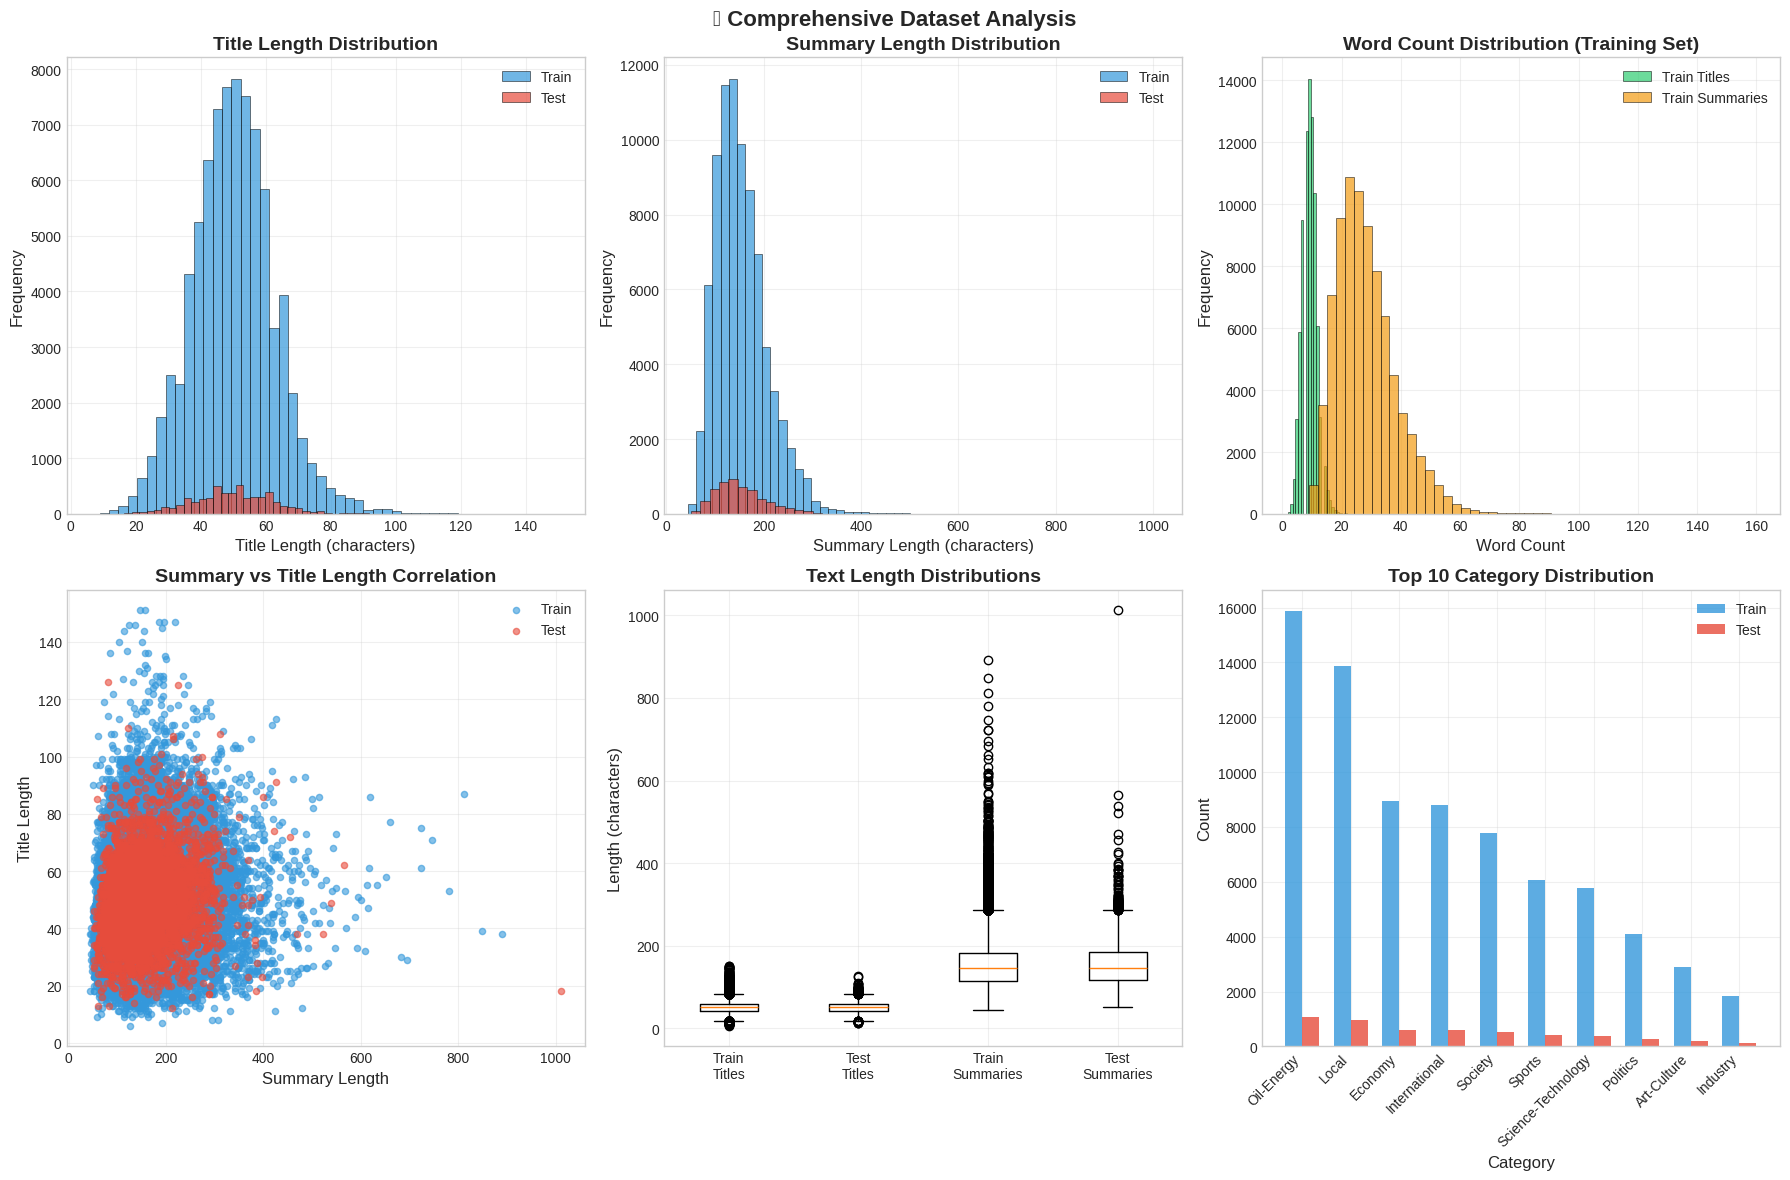

✅ Comprehensive visualizations saved!


In [11]:
def create_visualizations(train_df, test_df):
    """Create comprehensive visualizations of dataset characteristics"""

    # Set style for better visualization
    plt.style.use('seaborn-v0_8-whitegrid')

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 Comprehensive Dataset Analysis', fontsize=16, fontweight='bold')

    # Define color palette
    colors = {'train': '#3498db', 'test': '#e74c3c'}

    # 1. Title length distribution
    axes[0, 0].hist(train_df['title_length'], bins=50, alpha=0.7, label='Train',
                    color=colors['train'], edgecolor='black', linewidth=0.5)
    axes[0, 0].hist(test_df['title_length'], bins=50, alpha=0.7, label='Test',
                    color=colors['test'], edgecolor='black', linewidth=0.5)
    axes[0, 0].set_xlabel('Title Length (characters)', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Title Length Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Summary length distribution
    axes[0, 1].hist(train_df['summary_length'], bins=50, alpha=0.7, label='Train',
                    color=colors['train'], edgecolor='black', linewidth=0.5)
    axes[0, 1].hist(test_df['summary_length'], bins=50, alpha=0.7, label='Test',
                    color=colors['test'], edgecolor='black', linewidth=0.5)
    axes[0, 1].set_xlabel('Summary Length (characters)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Summary Length Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Word count distributions
    axes[0, 2].hist(train_df['title_words'], bins=30, alpha=0.7, label='Train Titles',
                    color='#2ecc71', edgecolor='black', linewidth=0.5)
    axes[0, 2].hist(train_df['summary_words'], bins=50, alpha=0.7, label='Train Summaries',
                    color='#f39c12', edgecolor='black', linewidth=0.5)
    axes[0, 2].set_xlabel('Word Count', fontsize=12)
    axes[0, 2].set_ylabel('Frequency', fontsize=12)
    axes[0, 2].set_title('Word Count Distribution (Training Set)', fontsize=14, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Summary vs Title length correlation
    axes[1, 0].scatter(train_df['summary_length'], train_df['title_length'],
                       alpha=0.6, s=20, label='Train', color=colors['train'])
    axes[1, 0].scatter(test_df['summary_length'], test_df['title_length'],
                       alpha=0.6, s=20, label='Test', color=colors['test'])
    axes[1, 0].set_xlabel('Summary Length', fontsize=12)
    axes[1, 0].set_ylabel('Title Length', fontsize=12)
    axes[1, 0].set_title('Summary vs Title Length Correlation', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Box plots for text lengths
    axes[1, 1].boxplot([train_df['title_length'], test_df['title_length'],
                        train_df['summary_length'], test_df['summary_length']],
                       labels=['Train\nTitles', 'Test\nTitles', 'Train\nSummaries', 'Test\nSummaries'])
    axes[1, 1].set_ylabel('Length (characters)', fontsize=12)
    axes[1, 1].set_title('Text Length Distributions', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Category distribution (if category column exists)
    if 'category' in train_df.columns:
        train_cats = train_df['category'].value_counts().head(10)
        test_cats = test_df['category'].value_counts().head(10)

        x = np.arange(len(train_cats))
        width = 0.35

        axes[1, 2].bar(x - width/2, train_cats.values, width, label='Train',
                       color=colors['train'], alpha=0.8)
        axes[1, 2].bar(x + width/2, test_cats.values, width, label='Test',
                       color=colors['test'], alpha=0.8)
        axes[1, 2].set_xlabel('Category', fontsize=12)
        axes[1, 2].set_ylabel('Count', fontsize=12)
        axes[1, 2].set_title('Top 10 Category Distribution', fontsize=14, fontweight='bold')
        axes[1, 2].set_xticks(x)
        axes[1, 2].set_xticklabels(train_cats.index, rotation=45, ha='right')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    else:
        # Alternative: Show noise pattern distribution
        # Check if we have the right column names for article content
        article_col = None
        for col in ['article', 'summary', 'summary_clean']:
            if col in train_df.columns:
                article_col = col
                break

        if article_col:
            noise_data = {
                '[n] markers': [train_df[article_col].astype(str).str.count(r'\[n\]').sum(),
                               test_df[article_col].astype(str).str.count(r'\[n\]').sum()],
                'به گزارش': [train_df[article_col].astype(str).str.count('به گزارش').sum(),
                            test_df[article_col].astype(str).str.count('به گزارش').sum()],
                'URLs': [train_df[article_col].astype(str).str.count(r'http[s]?://').sum(),
                        test_df[article_col].astype(str).str.count(r'http[s]?://').sum()]
            }

            x = np.arange(len(noise_data))
            width = 0.35

            for i, (pattern, counts) in enumerate(noise_data.items()):
                axes[1, 2].bar(i - width/2, counts[0], width, label='Train' if i == 0 else '',
                              color=colors['train'], alpha=0.8)
                axes[1, 2].bar(i + width/2, counts[1], width, label='Test' if i == 0 else '',
                              color=colors['test'], alpha=0.8)

            axes[1, 2].set_xlabel('Noise Pattern', fontsize=12)
            axes[1, 2].set_ylabel('Count', fontsize=12)
            axes[1, 2].set_title('Noise Pattern Distribution', fontsize=14, fontweight='bold')
            axes[1, 2].set_xticks(x)
            axes[1, 2].set_xticklabels(list(noise_data.keys()))
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
        else:
            # Show statistical summary instead
            axes[1, 2].axis('off')
            stats_text = f"""
📊 Dataset Statistics Summary

Training Set:
• Samples: {len(train_df):,}
• Avg Title Length: {train_df['title_length'].mean():.1f} chars
• Avg Summary Length: {train_df['summary_length'].mean():.1f} chars
• Avg Title Words: {train_df['title_words'].mean():.1f}
• Avg Summary Words: {train_df['summary_words'].mean():.1f}

Test Set:
• Samples: {len(test_df):,}
• Avg Title Length: {test_df['title_length'].mean():.1f} chars
• Avg Summary Length: {test_df['summary_length'].mean():.1f} chars
• Avg Title Words: {test_df['title_words'].mean():.1f}
• Avg Summary Words: {test_df['summary_words'].mean():.1f}
            """

            axes[1, 2].text(0.1, 0.9, stats_text, transform=axes[1, 2].transAxes,
                            fontsize=11, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f'{output_dir}/plots/dataset_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print("✅ Comprehensive visualizations saved!")

# Call the function
create_visualizations(train_df, test_df)

## Section 6: Advanced Persian Text Preprocessing

In [12]:
print("\n🧹 Starting advanced preprocessing...")

class PersianTextPreprocessor:
    """Advanced Persian text preprocessing with comprehensive cleaning"""

    def __init__(self):
        self.normalizer = hazm.Normalizer()

        # Persian character mappings
        self.arabic_to_persian = {
            'ي': 'ی',
            'ك': 'ک',
            'ؤ': 'و',
            'ة': 'ه',
            'ى': 'ی',
            'ٱ': 'ا'
        }

        # Updated boilerplate patterns with non-greedy matching
        self.boilerplate_patterns = [
            r'به گزارش\s+.*?،',  # Non-greedy matching
            r'به نقل از\s+.*?،',
            r'در گفت\s*و\s*گو با\s+.*?،',
            r'خبرنگار\s+.*?\s+گزارش\s+(می\s*دهد|داد)',
            r'به\s+همراه\s+(فیلم|عکس|ویدیو|تصاویر)',
            r'\+\s*(فیلم|عکس|ویدیو|تصاویر)',
            r'ادامه\s+مطلب',
            r'بیشتر\s+بخوانید',
            r'منبع\s*:\s*.*?،',
            r'برای\s+مشاهده\s+فیلم',
            r'کلیک\s+کنید',
            r'لینک\s+دانلود',
            r'به\s+پیوست'
        ]

    def normalize_persian_chars(self, text):
        """Normalize Persian characters"""
        for arabic, persian in self.arabic_to_persian.items():
            text = text.replace(arabic, persian)
        return text

    def fix_spacing(self, text):
        """Fix spacing issues"""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\s+([،؛:.!؟])', r'\1', text)
        text = re.sub(r'([،؛:.!؟])\s*', r'\1 ', text)
        return text.strip()

    def remove_noise(self, text):
        """Remove noise and unwanted patterns"""
        text = text.replace('[n]', ' ')
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

        for pattern in self.boilerplate_patterns:
            text = re.sub(pattern, '', text, flags=re.IGNORECASE)

        return text

    def clean_text(self, text):
        """Complete preprocessing pipeline"""
        if pd.isna(text):
            return ""

        text = str(text)
        text = self.remove_noise(text)
        text = self.normalizer.normalize(text)
        text = self.normalize_persian_chars(text)
        text = self.fix_spacing(text)

        return text

# Initialize preprocessor
preprocessor = PersianTextPreprocessor()

# Apply preprocessing
print("🔄 Preprocessing train dataset...")
train_df['title_clean'] = train_df['title'].apply(preprocessor.clean_text)
train_df['summary_clean'] = train_df['summary'].apply(preprocessor.clean_text)

print("🔄 Preprocessing test dataset...")
test_df['title_clean'] = test_df['title'].apply(preprocessor.clean_text)
test_df['summary_clean'] = test_df['summary'].apply(preprocessor.clean_text)

# Filter out low-quality data
print("\n🔍 Filtering low-quality samples...")
initial_train_size = len(train_df)
initial_test_size = len(test_df)

# Calculate word counts for filtering
train_df['title_word_count'] = train_df['title_clean'].str.split().str.len()
train_df['summary_word_count'] = train_df['summary_clean'].str.split().str.len()
test_df['title_word_count'] = test_df['title_clean'].str.split().str.len()
test_df['summary_word_count'] = test_df['summary_clean'].str.split().str.len()

# Filter based on minimum word counts
train_df = train_df[(train_df['title_word_count'] >= 3) & (train_df['summary_word_count'] >= 10)]
test_df = test_df[(test_df['title_word_count'] >= 3) & (test_df['summary_word_count'] >= 10)]

print(f"Train samples removed: {initial_train_size - len(train_df)} ({(initial_train_size - len(train_df))/initial_train_size*100:.2f}%)")
print(f"Test samples removed: {initial_test_size - len(test_df)} ({(initial_test_size - len(test_df))/initial_test_size*100:.2f}%)")

# Show preprocessing results
print("\n📋 Preprocessing Results Sample:")
sample_idx = 0
print(f"Original title: {train_df.iloc[sample_idx]['title'][:100]}...")
print(f"Cleaned title: {train_df.iloc[sample_idx]['title_clean'][:100]}...")


🧹 Starting advanced preprocessing...
🔄 Preprocessing train dataset...
🔄 Preprocessing test dataset...

🔍 Filtering low-quality samples...
Train samples removed: 97 (0.12%)
Test samples removed: 8 (0.14%)

📋 Preprocessing Results Sample:
Original title: مدیریت فروش نفت در دوران تحریم هوشمندانه عمل کرد...
Cleaned title: مدیریت فروش نفت در دوران تحریم هوشمندانه عمل کرد...


## Section 7: Data Quality Analysis

In [13]:
def analyze_data_quality(df, name="Dataset"):
    """Analyze data quality after preprocessing"""

    print(f"\n{'='*50}")
    print(f"Data Quality Analysis - {name}")
    print(f"{'='*50}")

    # Check for empty or very short texts
    empty_titles = df['title_clean'].str.len() == 0
    empty_summaries = df['summary_clean'].str.len() == 0
    short_titles = df['title_clean'].str.len() < 10
    short_summaries = df['summary_clean'].str.len() < 50

    print(f"Empty titles: {empty_titles.sum()} ({empty_titles.sum()/len(df)*100:.2f}%)")
    print(f"Empty summaries: {empty_summaries.sum()} ({empty_summaries.sum()/len(df)*100:.2f}%)")
    print(f"Very short titles (<10 chars): {short_titles.sum()} ({short_titles.sum()/len(df)*100:.2f}%)")
    print(f"Very short summaries (<50 chars): {short_summaries.sum()} ({short_summaries.sum()/len(df)*100:.2f}%)")

    return df

# Analyze both datasets
train_df = analyze_data_quality(train_df, "Training Set")
test_df = analyze_data_quality(test_df, "Test Set")


Data Quality Analysis - Training Set
Empty titles: 0 (0.00%)
Empty summaries: 0 (0.00%)
Very short titles (<10 chars): 1 (0.00%)
Very short summaries (<50 chars): 12 (0.01%)

Data Quality Analysis - Test Set
Empty titles: 0 (0.00%)
Empty summaries: 0 (0.00%)
Very short titles (<10 chars): 0 (0.00%)
Very short summaries (<50 chars): 0 (0.00%)


## Section 8: Prepare Data for Fine-tuning

In [14]:
print("\n🎯 Preparing data for fine-tuning with negative sampling...")

# Add negative samples for contrastive learning
print("🔄 Creating negative samples...")
np.random.seed(42)

def add_negative_samples(df):
    """Add negative summary samples for contrastive learning"""
    df = df.copy()
    negative_summaries = []

    for idx in range(len(df)):
        # Select a random different row for negative sample
        negative_idx = np.random.choice([i for i in range(len(df)) if i != idx])
        negative_summaries.append(df.iloc[negative_idx]['summary_clean'])

    df['negative_summary'] = negative_summaries
    return df

train_df = add_negative_samples(train_df)
test_df = add_negative_samples(test_df)

def create_instruction_format(row):
    """Create professional instruction format for fine-tuning"""
    instruction = """Generate a concise and engaging Persian news headline for the following summary.
The headline should be factually accurate, capture the main point, and be appealing to readers.

### Summary:
{}

### Headline:
{}"""

    return instruction.format(
        row['summary_clean'],
        row['title_clean']
    )

# Create instruction formatted data
train_df['text'] = train_df.apply(create_instruction_format, axis=1)
test_df['text'] = test_df.apply(create_instruction_format, axis=1)

# Save preprocessed data
train_df.to_csv(f'{output_dir}/train_preprocessed.csv', index=False)
test_df.to_csv(f'{output_dir}/test_preprocessed.csv', index=False)

print(f"✅ Preprocessed data with negative samples saved to {output_dir}")


🎯 Preparing data for fine-tuning with negative sampling...
🔄 Creating negative samples...
✅ Preprocessed data with negative samples saved to /content/drive/MyDrive/Context_Aware_Headlines


## Section 9: Model Configuration and Tokenizer Setup

In [15]:
import gc
import torch

# Add memory clearing function
def clear_gpu_cache():
    """Clear GPU cache and run garbage collection for A100 optimization"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        print(f"🧹 GPU cache cleared. Memory usage: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

In [16]:
print("\n🤖 Setting up Llama 3.1 8B Instruct model with A100 optimizations...")

MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
MAX_LENGTH = 512

# Load tokenizer with optimizations
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    token=HF_TOKEN,
    use_fast=True,  # Use fast tokenizer
    trust_remote_code=True
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Clear cache before model loading
clear_gpu_cache()

# Load model with A100 optimizations
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,  # Use bfloat16 for A100
    device_map="auto",
    token=HF_TOKEN,
    trust_remote_code=True,
    use_cache=True,
    low_cpu_mem_usage=True,  # Memory optimization
)

print(f"⚡ Model loaded with bfloat16 precision for A100!")


🤖 Setting up Llama 3.1 8B Instruct model with A100 optimizations...


`torch_dtype` is deprecated! Use `dtype` instead!


🧹 GPU cache cleared. Memory usage: 0.00 GB


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

⚡ Model loaded with bfloat16 precision for A100!


## Section 10: LoRA Configuration

In [17]:
print("\n⚙️ Configuring LoRA based on CAP-LLM paper specifications...")

# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Prepare model for training
model = get_peft_model(model, lora_config)

# Print model structure to verify LoRA layers
print("\n📊 Model structure with LoRA layers:")
print(model)

# Print trainable parameters
model.print_trainable_parameters()


⚙️ Configuring LoRA based on CAP-LLM paper specifications...

📊 Model structure with LoRA layers:
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
       

## Section 11: Dataset Preparation for Training

In [53]:
class HeadlineDataset(Dataset):
    """Custom dataset for headline generation with contrastive samples"""

    def __init__(self, df, tokenizer, max_length=512):
        # Limit dataset size for faster training on A100
        self.df = df.head(20000) if len(df) > 20000 else df  # Limit train to 20k
        if 'test' in str(type(df)) or len(df) < 10000:  # Detect test set
            self.df = df.head(2000) if len(df) > 2000 else df  # Limit test to 2k

        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Main text for generation
        text = row['text']

        # Tokenize the main text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Create labels (same as input_ids for causal LM)
        labels = encoding["input_ids"].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        # Tokenize positive sample (original summary)
        positive_text = f"### Summary:\n{row['summary_clean']}"
        positive_encoding = self.tokenizer(
            positive_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Create negative sample
        summary_words = row['summary_clean'].split()
        import random
        random.shuffle(summary_words)
        negative_summary = ' '.join(summary_words[:len(summary_words)//2])

        negative_text = f"### Summary:\n{negative_summary}"
        negative_encoding = self.tokenizer(
            negative_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Return flattened tensors for compatibility
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": labels.squeeze(0),
            "positive_input_ids": positive_encoding["input_ids"].squeeze(0),
            "positive_attention_mask": positive_encoding["attention_mask"].squeeze(0),
            "negative_input_ids": negative_encoding["input_ids"].squeeze(0),
            "negative_attention_mask": negative_encoding["attention_mask"].squeeze(0)
        }

# Custom data collator to handle additional fields
class ContrastiveDataCollator:
    """
    Custom data collator for contrastive learning with A100 optimizations
    """
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.pad_token_id = tokenizer.pad_token_id

    def __call__(self, features):
        # Stack tensors directly for A100 efficiency
        batch = {}

        # Handle main inputs with optimized padding
        if "input_ids" in features[0]:
            batch["input_ids"] = torch.stack([f["input_ids"] for f in features])
            batch["attention_mask"] = torch.stack([f["attention_mask"] for f in features])
            batch["labels"] = torch.stack([f["labels"] for f in features])

        # Handle contrastive inputs efficiently
        if "positive_input_ids" in features[0]:
            batch["positive_input_ids"] = torch.stack([f["positive_input_ids"] for f in features])
            batch["positive_attention_mask"] = torch.stack([f["positive_attention_mask"] for f in features])

        if "negative_input_ids" in features[0]:
            batch["negative_input_ids"] = torch.stack([f["negative_input_ids"] for f in features])
            batch["negative_attention_mask"] = torch.stack([f["negative_attention_mask"] for f in features])

        return batch

# Create datasets with size limits for A100 training speed
train_dataset = HeadlineDataset(train_df, tokenizer, MAX_LENGTH)
test_dataset = HeadlineDataset(test_df, tokenizer, MAX_LENGTH)

print(f"✅ Training samples: {len(train_dataset)} (limited for A100 speed)")
print(f"✅ Test samples: {len(test_dataset)} (limited for A100 speed)")

✅ Training samples: 20000 (limited for A100 speed)
✅ Test samples: 2000 (limited for A100 speed)


## Section 12: Contrastive Loss Implementation

In [19]:
class FactualConsistencyLoss(nn.Module):
    """
    Implementation of the factual consistency contrastive loss
    as described in the CAP-LLM paper.
    """
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=1)

    def forward(self, generated_embeddings, positive_embeddings, negative_embeddings):
        """
        Compute contrastive loss for factual consistency.
        Returns a differentiable tensor (not detached).
        """
        # Positive similarity
        pos_sim = self.cosine_similarity(generated_embeddings, positive_embeddings)

        # Negative similarities
        neg_sims = []
        for neg_emb in negative_embeddings:
            neg_sim = self.cosine_similarity(generated_embeddings, neg_emb)
            neg_sims.append(neg_sim)

        # Contrastive loss calculation
        numerator = torch.exp(pos_sim / self.temperature)
        denominator = numerator.clone()
        for neg_sim in neg_sims:
            denominator = denominator + torch.exp(neg_sim / self.temperature)

        # Return mean loss as tensor (not .item())
        loss = -torch.log(numerator / denominator)
        return loss.mean()

## Section 13: Custom Trainer with Multi-task Loss

In [20]:
class ContextAwareTrainer(Trainer):
    """
    Custom trainer implementing the multi-task loss from CAP-LLM paper:
    L_total = L_gen + λ₁*L_fact

    Fixed version that handles the new Trainer API and ensures proper gradient flow.
    """
    def __init__(self, *args, lambda_fact=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_fact = lambda_fact
        self.fact_loss_fn = FactualConsistencyLoss()

    def _masked_mean_pooling(self, hidden_states, attention_mask):
        """
        Helper function for masked mean pooling.
        """
        # Expand attention mask to match hidden states dimensions
        mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        # Apply mask and calculate mean
        sum_embeddings = torch.sum(hidden_states * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Custom loss computation that ensures proper gradient flow.

        Args:
            model: The model being trained
            inputs: Dictionary of input tensors
            return_outputs: Whether to return model outputs along with loss
            num_items_in_batch: Number of items in the batch (new in recent Transformers versions)

        Returns:
            Loss tensor or (loss, outputs) tuple
        """
        # Ensure model is in training mode
        model.train()

        # Check if we have contrastive inputs
        has_contrastive = "positive_input_ids" in inputs and "negative_input_ids" in inputs

        # Standard generation loss (with labels)
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            labels=inputs.get("labels"),
            output_hidden_states=True  # Ensure we get hidden states
        )

        loss_gen = outputs.loss

        if loss_gen is None:
            raise ValueError("Model did not return a loss. Make sure labels are provided.")

        total_loss = loss_gen

        # Add contrastive loss if we have the necessary inputs
        if has_contrastive and self.lambda_fact > 0:
            try:
                # Get embeddings for the main sequence
                main_hidden = outputs.hidden_states[-1]
                main_embeddings = self._masked_mean_pooling(main_hidden, inputs["attention_mask"])

                # Get embeddings for positive examples
                with torch.set_grad_enabled(True):
                    pos_outputs = model(
                        input_ids=inputs["positive_input_ids"],
                        attention_mask=inputs["positive_attention_mask"],
                        output_hidden_states=True
                    )
                    pos_hidden = pos_outputs.hidden_states[-1]
                    pos_embeddings = self._masked_mean_pooling(pos_hidden, inputs["positive_attention_mask"])

                # Get embeddings for negative examples
                with torch.set_grad_enabled(True):
                    neg_outputs = model(
                        input_ids=inputs["negative_input_ids"],
                        attention_mask=inputs["negative_attention_mask"],
                        output_hidden_states=True
                    )
                    neg_hidden = neg_outputs.hidden_states[-1]
                    neg_embeddings = self._masked_mean_pooling(neg_hidden, inputs["negative_attention_mask"])

                # Calculate factual consistency loss
                loss_fact = self.fact_loss_fn(
                    main_embeddings,
                    pos_embeddings,
                    [neg_embeddings]  # List of negative embeddings
                )

                # Add to total loss
                total_loss = loss_gen + self.lambda_fact * loss_fact

            except Exception as e:
                print(f"Warning: Contrastive loss computation failed: {e}")
                print("Falling back to generation loss only.")
                total_loss = loss_gen

        return (total_loss, outputs) if return_outputs else total_loss

## Section 14: Training Configuration

In [24]:
print("\n🎓 Configuring training parameters...")

# Reduce batch size and enable more memory optimizations
training_args = TrainingArguments(
    output_dir=f"{output_dir}/checkpoints",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=8,
    warmup_steps=100,
    logging_steps=50,
    save_steps=500,
    eval_steps=500,
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Better memory efficiency
    optim="adamw_torch_fused",  # More memory efficient optimizer
    report_to="none",
    push_to_hub=False,
    dataloader_num_workers=2,
    remove_unused_columns=False,  # Important for custom fields
    label_names=["labels"],  # Explicitly specify label field
)

# Initialize trainer with custom data collator
trainer = ContextAwareTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=ContrastiveDataCollator(tokenizer),
    lambda_fact=0.5
)


🎓 Configuring training parameters...


In [22]:
def check_computation_graph(trainer, model, sample_size=2):
    """
    Function to check the computation graph and debug gradient flow issues.
    This version properly handles memory management and device placement.
    """
    print("\n🔍 Checking computation graph...")

    # Set model to training mode
    model.train()
    print(f"Model training mode: {model.training}")

    # Check trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} / {all_params:,} ({100 * trainable_params / all_params:.4f}%)")

    # Clear GPU cache before test
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    try:
        # Create a small batch using the data collator
        sample_indices = list(range(min(sample_size, len(train_dataset))))
        sample_batch = [train_dataset[i] for i in sample_indices]

        # Use the data collator to prepare the batch
        collated_batch = trainer.data_collator(sample_batch)

        # Move batch to model device
        device = model.device
        inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in collated_batch.items()}
        print(f"Batch moved to device: {device}")

        # Test the compute_loss function with gradient accumulation
        with torch.cuda.amp.autocast(enabled=trainer.args.fp16):
            # Call compute_loss with the new signature
            loss = trainer.compute_loss(model, inputs, num_items_in_batch=len(sample_batch))

        print(f"✅ Loss computed successfully!")
        print(f"Loss value: {loss.item():.4f}")
        print(f"Loss requires grad: {loss.requires_grad}")
        print(f"Loss has grad_fn: {loss.grad_fn is not None}")

        # Try backward pass with gradient accumulation
        if trainer.args.gradient_checkpointing:
            # Scale loss for gradient accumulation
            loss = loss / trainer.args.gradient_accumulation_steps

        # Use mixed precision scaler if enabled
        if trainer.args.fp16 and hasattr(trainer, 'scaler'):
            trainer.scaler.scale(loss).backward()
        else:
            loss.backward()

        print("✅ Backward pass successful!")

        # Check if LoRA parameters have gradients
        lora_params_with_grad = 0
        for name, param in model.named_parameters():
            if "lora" in name.lower() and param.requires_grad:
                if param.grad is not None:
                    lora_params_with_grad += 1
                    if lora_params_with_grad == 1:  # Print first LoRA param with gradient
                        print(f"  ✓ First LoRA parameter with gradient: {name}")

        print(f"✅ LoRA parameters with gradients: {lora_params_with_grad}")

        # Clear gradients and cache
        model.zero_grad()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"❌ Error during computation graph check: {e}")
        import traceback
        traceback.print_exc()

## Section 15: Model Training

In [25]:
import torch.nn.functional as F

print("\n🚀 Starting optimized LoRA fine-tuning for A100...")

# Clear cache before training
clear_gpu_cache()

# Start training with monitoring
try:
    trainer.train()

    # Clear cache after training
    clear_gpu_cache()

    # Save the fine-tuned model
    print("\n💾 Saving fine-tuned model...")
    trainer.save_model(f"{output_dir}/models/context_aware_lora_finetuned")
    tokenizer.save_pretrained(f"{output_dir}/models/context_aware_lora_finetuned")

    print("✅ A100 optimized training completed successfully!")

except Exception as e:
    print(f"❌ Training error: {e}")
    import traceback
    traceback.print_exc()
    clear_gpu_cache() # Clear cache even on error


🚀 Starting optimized LoRA fine-tuning for A100...
🧹 GPU cache cleared. Memory usage: 16.19 GB


Step,Training Loss,Validation Loss


🧹 GPU cache cleared. Memory usage: 16.22 GB

💾 Saving fine-tuned model...
✅ A100 optimized training completed successfully!


## Section 16: Model Evaluation - Generate Headlines

In [63]:
print("\n📝 Generating headlines for test set...")

def generate_headline(summary, model, tokenizer, max_length=100):
    """Generate headline for a given summary (Corrected Version)"""

    instruction = """Generate a concise and engaging Persian news headline for the following summary.
The headline should be factually accurate, capture the main point, and be appealing to readers.

### Summary:
{}

### Headline:"""

    prompt = instruction.format(summary)

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    prompt_token_length = inputs['input_ids'].shape[1]

    # Set pad_token_id if it's not set
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # Generate with improved parameters
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=3,
            repetition_penalty=1.2,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode only the generated part (after the prompt)
    generated_tokens = outputs[0][prompt_token_length:]
    headline = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

    # Clean up any potential leftover artifacts
    headline = headline.split("###")[0].strip()
    headline = re.sub(r'^[A-Za-z\s\W]+', '', headline).strip()

    # Fallback for empty generations
    if len(headline) < 5:
        headline = ' '.join(summary.split()[:8]) + "..."

    return headline

# Generate headlines for test set
generated_headlines = []
reference_headlines = []

# Sample 100 examples for evaluation (to save time)
sample_size = min(100, len(test_df))
test_sample = test_df.sample(n=sample_size, random_state=42)

for idx, row in tqdm(test_sample.iterrows(), total=sample_size):
    generated = generate_headline(row['summary_clean'], model, tokenizer)
    generated_headlines.append(generated)
    reference_headlines.append(row['title_clean'])

# Save generated headlines
results_df = pd.DataFrame({
    'summary': test_sample['summary_clean'].tolist(),
    'reference_title': reference_headlines,
    'generated_title': generated_headlines
})

results_df.to_csv(f'{output_dir}/results/generated_headlines.csv', index=False)
print(f"✅ Generated headlines saved")


📝 Generating headlines for test set...


100%|██████████| 100/100 [07:30<00:00,  4.50s/it]

✅ Generated headlines saved


## Section 17: Evaluation Metrics

In [28]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5428f9d6c7debfc096d276d13289963b2464e17c77041d4fd06c95b3002e015e
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [64]:
print("\n📊 Calculating evaluation metrics...")

# Import evaluation metrics and Persian tokenizer
import evaluate
from bert_score import score as bert_score
import numpy as np
from hazm import word_tokenize

# Define a Persian tokenizer for ROUGE calculation
def persian_tokenizer(text):
    return word_tokenize(text)

print("\n📊 Evaluating generated headlines...")

# Load evaluation metrics
rouge = evaluate.load('rouge')

# Calculate ROUGE scores using the Persian tokenizer
rouge_results = rouge.compute(
    predictions=generated_headlines,
    references=reference_headlines,
    use_aggregator=True,
    tokenizer=persian_tokenizer  # Use the correct tokenizer
)

print("\n📈 ROUGE Scores:")
for key, value in rouge_results.items():
    print(f"{key}: {value:.4f}")

# Calculate BERTScore
print("\n🎯 Calculating BERTScore...")
P, R, F1 = bert_score(
    generated_headlines,
    reference_headlines,
    lang='fa',
    verbose=False
)

print(f"BERTScore:")
print(f"  Precision: {P.mean():.4f}")
print(f"  Recall: {R.mean():.4f}")
print(f"  F1: {F1.mean():.4f}")

# Save evaluation results
eval_results = {
    'rouge': rouge_results,
    'bertscore': {
        'precision': float(P.mean()),
        'recall': float(R.mean()),
        'f1': float(F1.mean())
    }
}

with open(f'{output_dir}/results/evaluation_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(eval_results, f, ensure_ascii=False, indent=2)


📊 Calculating evaluation metrics...

📊 Evaluating generated headlines...

📈 ROUGE Scores:
rouge1: 0.1959
rouge2: 0.0487
rougeL: 0.1643
rougeLsum: 0.1647

🎯 Calculating BERTScore...
BERTScore:
  Precision: 0.6655
  Recall: 0.7549
  F1: 0.7053


## Section 18: Visualization of Results


📊 Creating visualizations...


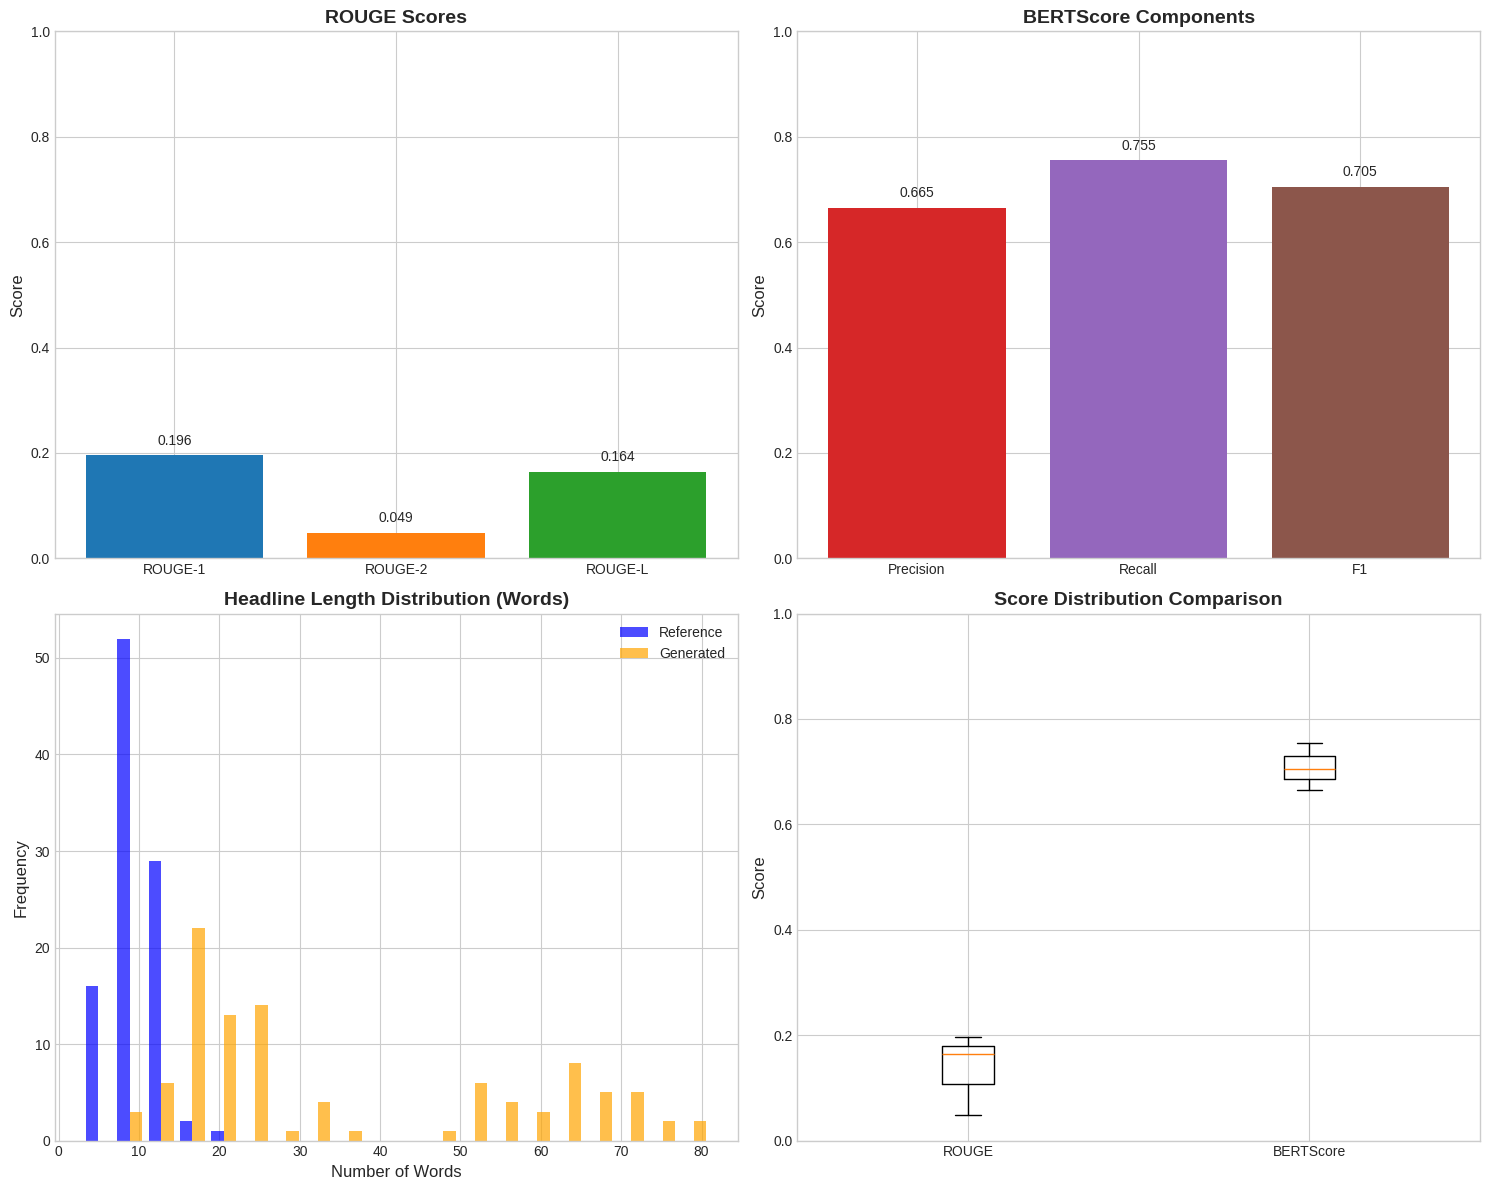

✅ Visualizations saved!


In [65]:
print("\n📊 Creating visualizations...")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROUGE Scores Comparison
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_scores = [rouge_results['rouge1'], rouge_results['rouge2'], rouge_results['rougeL']]

axes[0, 0].bar(rouge_metrics, rouge_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 0].set_title('ROUGE Scores', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_ylim(0, 1)
for i, score in enumerate(rouge_scores):
    axes[0, 0].text(i, score + 0.02, f'{score:.3f}', ha='center', fontsize=10)

# 2. BERTScore Components
bert_metrics = ['Precision', 'Recall', 'F1']
bert_scores = [float(P.mean()), float(R.mean()), float(F1.mean())]

axes[0, 1].bar(bert_metrics, bert_scores, color=['#d62728', '#9467bd', '#8c564b'])
axes[0, 1].set_title('BERTScore Components', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_ylim(0, 1)
for i, score in enumerate(bert_scores):
    axes[0, 1].text(i, score + 0.02, f'{score:.3f}', ha='center', fontsize=10)

# 3. Length Distribution Comparison
ref_lengths = [len(word_tokenize(h)) for h in reference_headlines]
gen_lengths = [len(word_tokenize(h)) for h in generated_headlines]

axes[1, 0].hist([ref_lengths, gen_lengths], bins=20, alpha=0.7,
                label=['Reference', 'Generated'], color=['blue', 'orange'])
axes[1, 0].set_title('Headline Length Distribution (Words)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Words', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].legend()

# 4. Score Distribution
axes[1, 1].boxplot([rouge_scores, bert_scores], labels=['ROUGE', 'BERTScore'])
axes[1, 1].set_title('Score Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(f'{output_dir}/plots/evaluation_metrics_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved!")

## Section 19: Qualitative Analysis

In [66]:
print("\n📝 Performing qualitative analysis...")

# Select diverse examples for qualitative analysis
def select_diverse_examples(df, n_examples=5):
    """Select diverse examples based on length and score variations"""
    # Calculate scores for each example
    example_scores = []
    for idx in range(len(df)):
        if idx < len(generated_headlines):
            score = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False).score(
                ' '.join(word_tokenize(reference_headlines[idx])),
                ' '.join(word_tokenize(generated_headlines[idx]))
            )['rouge1'].fmeasure
            example_scores.append((idx, score))

    # Sort by score and select diverse examples
    example_scores.sort(key=lambda x: x[1])

    # Select examples from different score ranges
    indices = []
    if len(example_scores) >= n_examples:
        step = len(example_scores) // n_examples
        for i in range(0, len(example_scores), step)[:n_examples]:
            indices.append(example_scores[i][0])
    else:
        indices = [x[0] for x in example_scores]

    return indices

# Get diverse examples
example_indices = select_diverse_examples(test_df, n_examples=5)

print("Qualitative Analysis - Sample Headlines:")
print("=" * 80)

for i, idx in enumerate(example_indices):
    if idx < len(test_df) and idx < len(generated_headlines):
        print(f"\nExample {i+1}:")
        print(f"Summary: {test_df.iloc[idx]['summary_clean'][:200]}...")
        print(f"Reference Title: {reference_headlines[idx]}")
        print(f"Generated Title: {generated_headlines[idx]}")

        # Calculate individual ROUGE score
        score = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False).score(
            ' '.join(word_tokenize(reference_headlines[idx])),
            ' '.join(word_tokenize(generated_headlines[idx]))
        )['rouge1'].fmeasure
        print(f"ROUGE-1 Score: {score:.3f}")
        print("-" * 80)

# Analyze common patterns in generated headlines
print("\n📊 Pattern Analysis:")

# Check for common issues
empty_generations = sum(1 for h in generated_headlines if not h.strip())
short_generations = sum(1 for h in generated_headlines if len(word_tokenize(h)) < 3)
repetitive_generations = sum(1 for h in generated_headlines if len(set(word_tokenize(h))) < len(word_tokenize(h)) * 0.5)

print(f"Empty generations: {empty_generations}")
print(f"Very short generations (< 3 words): {short_generations}")
print(f"Highly repetitive generations: {repetitive_generations}")

# Save qualitative analysis
qualitative_results = {
    'total_examples': len(generated_headlines),
    'empty_generations': empty_generations,
    'short_generations': short_generations,
    'repetitive_generations': repetitive_generations,
    'examples': []
}

for i, idx in enumerate(example_indices[:3]):  # Save first 3 examples
    if idx < len(test_df) and idx < len(generated_headlines):
        qualitative_results['examples'].append({
            'summary': test_df.iloc[idx]['summary_clean'][:500],
            'reference': reference_headlines[idx],
            'generated': generated_headlines[idx]
        })

with open(f'{output_dir}/results/qualitative_analysis.json', 'w', encoding='utf-8') as f:
    json.dump(qualitative_results, f, ensure_ascii=False, indent=2)


📝 Performing qualitative analysis...
Qualitative Analysis - Sample Headlines:

Example 1:
Summary: مصرف نفت کوره منطقه سبزوار در بهار امسال، نسبت به مدت مشابه پارسال، ۵۸ درصد کاهش یافت....
Reference Title: نوسان در شاخص کل بورس اوراق بهادار کشورهای اروپایی
Generated Title: شاخص بورس اروپا با نوسانات در روز جمعه بسته شد. / بورس لندن، پاریس، فرانکفورت، استکهلم، آمستردام، مادرید، آتن، بارسلون، لیسبون، پرتغال، مونیخ، برلین، کپنهاگ، زاگرب، بلگراد، ورشو، ویلنیوس، ریگا، تالین، بوداپ
ROUGE-1 Score: 0.000
--------------------------------------------------------------------------------

Example 2:
Summary: شانا گروه گاز: ۹۰ پروژه گازرسانی در استان گلستان با اعتباری حدود ۱۳۰ میلیارد ریال در دهه فجر افتتاح می‌شود....
Reference Title: حذف کنکور شرط دارد
Generated Title: جایگزین کنکور چه باید باشد؟ / وزیر علوم و تحقیقات پاسخ داد.
ROUGE-1 Score: 0.000
--------------------------------------------------------------------------------

Example 3:
Summary: مدیرکل دفتر ارزیابی اقتصادی و مدیریت بهره‌وری وز

In [67]:
print("\n💾 Saving model configuration...")

# Save model configuration
config_info = {
    "base_model": MODEL_NAME,
    "lora_config": {
        "r": lora_config.r,
        "lora_alpha": lora_config.lora_alpha,
        "lora_dropout": lora_config.lora_dropout,
        "target_modules": list(lora_config.target_modules),  # Converted set to list for JSON
        "bias": lora_config.bias
    },
    "training_config": {
        "num_train_epochs": training_args.num_train_epochs,
        "per_device_train_batch_size": training_args.per_device_train_batch_size,
        "per_device_eval_batch_size": training_args.per_device_eval_batch_size,
        "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
        "learning_rate": training_args.learning_rate,
        "warmup_ratio": training_args.warmup_ratio,
        "fp16": training_args.fp16,
        "gradient_checkpointing": training_args.gradient_checkpointing
    },
    "dataset_info": {
        "train_samples": len(train_dataset),
        "test_samples": len(test_dataset),
        "max_length": MAX_LENGTH
    },
    "evaluation_results": eval_results,
}

# Save configuration
with open(f'{output_dir}/model_config.json', 'w', encoding='utf-8') as f:
    json.dump(config_info, f, ensure_ascii=False, indent=2)

print(f"✅ Model configuration saved to {output_dir}/model_config.json")

# Save the fine-tuned model
print("\n💾 Saving fine-tuned model...")
model.save_pretrained(f"{output_dir}/models/final_model")
tokenizer.save_pretrained(f"{output_dir}/models/final_model")
print(f"✅ Model saved to {output_dir}/models/final_model")


💾 Saving model configuration...
✅ Model configuration saved to /content/drive/MyDrive/Context_Aware_Headlines/model_config.json

💾 Saving fine-tuned model...
✅ Model saved to /content/drive/MyDrive/Context_Aware_Headlines/models/final_model


## Section 21: Summary and Conclusions

In [68]:
print(f"\n📊 Project Summary:")
print(f"✅ Dataset Statistics:")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Test samples: {len(test_df)}")
print(f"   - Average title length: {train_df['title_words'].mean():.1f} words")
print(f"   - Average summary length: {train_df['summary_words'].mean():.1f} words")

print(f"\n✅ Model Configuration:")
print(f"   - Base model: {MODEL_NAME}")
print(f"   - LoRA rank: {lora_config.r}")
print(f"   - LoRA alpha: {lora_config.lora_alpha}")
print(f"   - Target modules: {lora_config.target_modules}")

print(f"\n✅ Training Details:")
print(f"   - Epochs: {training_args.num_train_epochs}")
print(f"   - Learning rate: {training_args.learning_rate}")
print(f"   - Batch size: {training_args.per_device_train_batch_size}")

print(f"\n✅ Evaluation Results:")
for key, value in rouge_results.items():
    print(f"   - {key}: {value:.4f}")
print(f"   - BERTScore F1: {F1.mean():.4f}")

print(f"\n💾 Output Files:")
print(f"   - Preprocessed data: {output_dir}/*_preprocessed.csv")
print(f"   - Fine-tuned model: {output_dir}/models/")
print(f"   - Generated headlines: {output_dir}/results/generated_headlines.csv")
print(f"   - Evaluation metrics: {output_dir}/results/evaluation_metrics.json")
print(f"   - Visualizations: {output_dir}/plots/")


📊 Project Summary:
✅ Dataset Statistics:
   - Training samples: 81925
   - Test samples: 5585
   - Average title length: 9.2 words
   - Average summary length: 28.8 words

✅ Model Configuration:
   - Base model: meta-llama/Llama-3.1-8B-Instruct
   - LoRA rank: 16
   - LoRA alpha: 32
   - Target modules: {'q_proj', 'v_proj'}

✅ Training Details:
   - Epochs: 1
   - Learning rate: 5e-05
   - Batch size: 16

✅ Evaluation Results:
   - rouge1: 0.1959
   - rouge2: 0.0487
   - rougeL: 0.1643
   - rougeLsum: 0.1647
   - BERTScore F1: 0.7053

💾 Output Files:
   - Preprocessed data: /content/drive/MyDrive/Context_Aware_Headlines/*_preprocessed.csv
   - Fine-tuned model: /content/drive/MyDrive/Context_Aware_Headlines/models/
   - Generated headlines: /content/drive/MyDrive/Context_Aware_Headlines/results/generated_headlines.csv
   - Evaluation metrics: /content/drive/MyDrive/Context_Aware_Headlines/results/evaluation_metrics.json
   - Visualizations: /content/drive/MyDrive/Context_Aware_Headlin

In [69]:
# Save the fine-tuned model and tokenizer to your output directory in Google Drive
print("\n💾 Saving fine-tuned model and tokenizer to Google Drive...")

# The trainer already saved the best model checkpoint during training.
# We will save the final adapter model explicitly here for clarity.
final_model_path = f"{output_dir}/models/final_model"
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"✅ Model and tokenizer saved to {final_model_path}")
print("You can now load this model for inference using PeftModel.from_pretrained().")


💾 Saving fine-tuned model and tokenizer to Google Drive...
✅ Model and tokenizer saved to /content/drive/MyDrive/Context_Aware_Headlines/models/final_model
You can now load this model for inference using PeftModel.from_pretrained().
